In [1]:
import os
from zipfile import ZipFile
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import scipy
import util

In [2]:
executed_on_colab = False

if executed_on_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
    %cd /content/gdrive/My Drive/Kaggle
    %pwd
    !kaggle datasets download -d grassknoted/asl-alphabet

In [30]:
zip_path = "./archive.zip"
data_path = "./data/"

#with ZipFile(zip_path, 'r') as zipObj:
#    zipObj.extractall(data_path)
#    print(f"Extracted to {data_path}")

In [3]:
# The extracted data is uneccesary nested - move the inner folder to the root of training/test folders respectively
old_training_data_path = "./data/asl_alphabet_train/"
old_test_data_path = "./data/asl_alphabet_test/"

training_data_path = "./data/training/"
test_data_path = "./data/validation/"

source_training_data_path = os.path.join(old_training_data_path, "asl_alphabet_train/")
source_test_data_path = os.path.join(old_test_data_path, "asl_alphabet_test/")

In [4]:
shutil.copytree(source_training_data_path, training_data_path)
shutil.copytree(source_test_data_path, test_data_path)

shutil.rmtree(old_training_data_path)
shutil.rmtree(old_test_data_path)

# Inspect the data

In [4]:
def file_amount(path):
    asserted_size = 3000
    different_size = False
    for root, _, files in os.walk(path, topdown=False):
        if root.split("/")[-1] == "":
            continue
        if len(files) != asserted_size:
            different_size = True
            print(f"{root} has {len(files)} files")
    if different_size:
        print(f"Not all directories in {path} have the same amount of files each")
    else:
        print(f"All directories in {path} have {asserted_size} files each")

file_amount(training_data_path)
file_amount(test_data_path)

All directories in ./data/training/ have 3000 files each
./data/validation/A has 1 files
./data/validation/B has 1 files
./data/validation/C has 1 files
./data/validation/D has 1 files
./data/validation/del has 0 files
./data/validation/E has 1 files
./data/validation/F has 1 files
./data/validation/G has 1 files
./data/validation/H has 1 files
./data/validation/I has 1 files
./data/validation/J has 1 files
./data/validation/K has 1 files
./data/validation/L has 1 files
./data/validation/M has 1 files
./data/validation/N has 1 files
./data/validation/nothing has 1 files
./data/validation/O has 1 files
./data/validation/P has 1 files
./data/validation/Q has 1 files
./data/validation/R has 1 files
./data/validation/S has 1 files
./data/validation/space has 1 files
./data/validation/T has 1 files
./data/validation/U has 1 files
./data/validation/V has 1 files
./data/validation/W has 1 files
./data/validation/X has 1 files
./data/validation/Y has 1 files
./data/validation/Z has 1 files
Not

### Ideas
- Split some of the validation data into unseen data to test the model later
- Import as grayscale instead of RGB?

In [5]:
# Find all the different categories:
categories_list = []
for root, dirs, files in os.walk(training_data_path, topdown=False):
    if root.split("/")[-1] == "":
        continue
    categories_list.append(root.split("/")[-1])

categories_list.sort()
categories_dict = {key: value for (key, value) in enumerate(categories_list)}

num_categories = len(categories_dict)
print(f"Total number of categories: {num_categories}")

Total number of categories: 29


In [6]:
restructure_validation = False

# Need to put all the validation data into a single folder for the data generator to work
if restructure_validation:
    for category in categories_list:
        # Create the empty folder
        source_path = os.path.join(test_data_path, category)
        os.mkdir(source_path)

    # Move the file to corresponding folder
    for filename in os.listdir(test_data_path):
        file_path = os.path.join(test_data_path, filename)
        file_category = filename.split("_")[0]
        destination_path = os.path.join(test_data_path, file_category)
        shutil.move(file_path, destination_path)

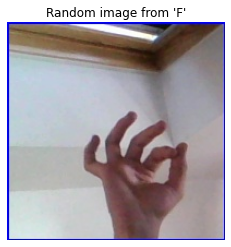

In [10]:
# Get a random image from the training set and test set
def get_random_image(from_validation=False, seed=None):
    if (seed):
        random.seed(seed)
    random_category = random.choice(categories_list)
    random_category_path = os.path.join(test_data_path if from_validation else training_data_path, random_category)
    random_image_path = random.choice(os.listdir(random_category_path))
    image = mpimg.imread(os.path.join(random_category_path, random_image_path))
    return (image, random_category)

image, image_category = get_random_image()
target_size = image.shape

util.show_image(image, title=f"Random image from '{image_category}'")


C:\Users\olest\AppData\Local\Temp/ipykernel_11724/1803490638.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_images = np.asarray([get_random_image(from_validation=True, seed=i*42) for i in range(10)])


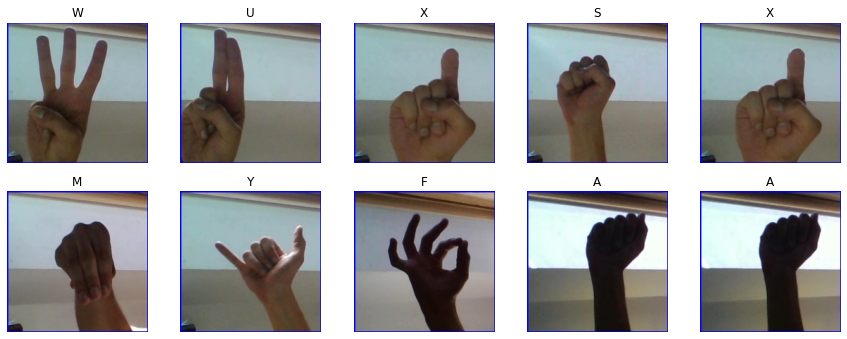

In [12]:
random_images = np.asarray([get_random_image(from_validation=True, seed=i*42) for i in range(10)])
images, titles = random_images[:,0], random_images[:,1]

util.show_images(images, image_titles=titles)

In [14]:
# Randomly split some of the training data into validation data
def sample_images_from_category(category, amount, seed=None, from_validation=False):
    if (seed):
        random.seed(seed)
    category_path = os.path.join(test_data_path if from_validation else training_data_path, category)
    image_path_samples = random.sample(os.listdir(category_path), amount)
    return image_path_samples

# 10% of the training data will be used for validation
split = 0.1
amount = int(3000 * split) # TODO: Change this to be the len of some folder

def move_images_to_validation(amount):
    for category in categories_list:
        image_path_samples = sample_images_from_category(category, amount, seed=42)
        for image_path in image_path_samples:
            source_path = os.path.join(training_data_path, category, image_path)
            destination_path = os.path.join(test_data_path, category)
            shutil.move(source_path, destination_path)

# move_images_to_validation(amount)

# All the data is now preprocessed into their own labelled directory

In [66]:
# Training hyperparameters

EPOCHS = 20
BATCH_SIZE_TRAINING = 64
BATCH_SIZE_VALIDATION = 64
#STEPS_PER_EPOCH = 78300 // BATCH_SIZE_TRAINING
#VALIDATION_STEPS = 8728 // BATCH_SIZE_VALIDATION
STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 100


In [67]:
# Use imagegenetor to generate a batch of images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# TODO: Add augmentation
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    training_data_path,
    target_size=target_size[:-1],
    batch_size=BATCH_SIZE_TRAINING,
    class_mode='categorical',
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(
    test_data_path,
    target_size=target_size[:-1],
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode='categorical',
)

Found 78300 images belonging to 29 classes.
Found 8728 images belonging to 29 classes.


# Define the model

In [68]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=target_size),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=target_size),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=target_size),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_categories, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 99, 99, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 23, 23, 64)      

In [69]:
# Checkpoint callback
checkpoint_path = "./data/training_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [70]:
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
)

Epoch 1/20
100/100 [==============================] - 21s 202ms/step - loss: 3.0368 - accuracy: 0.1689 - val_loss: 2.2398 - val_accuracy: 0.3508
Epoch 2/20
100/100 [==============================] - 20s 198ms/step - loss: 1.8005 - accuracy: 0.4592 - val_loss: 1.4332 - val_accuracy: 0.5494
Epoch 3/20
100/100 [==============================] - 20s 195ms/step - loss: 1.1397 - accuracy: 0.6502 - val_loss: 0.8841 - val_accuracy: 0.7300
Epoch 4/20
100/100 [==============================] - 19s 194ms/step - loss: 0.7613 - accuracy: 0.7591 - val_loss: 0.6955 - val_accuracy: 0.7677
Epoch 5/20
100/100 [==============================] - 19s 195ms/step - loss: 0.5264 - accuracy: 0.8330 - val_loss: 0.4546 - val_accuracy: 0.8512
Epoch 6/20
100/100 [==============================] - 19s 194ms/step - loss: 0.3808 - accuracy: 0.8730 - val_loss: 0.3653 - val_accuracy: 0.8730
Epoch 7/20
100/100 [==============================] - 19s 194ms/step - loss: 0.3094 - accuracy: 0.8982 - val_loss: 0.3304 - val_ac

In [31]:
def save_history(history, file_name = "cnn_history_1.npy"):
    history_path = os.path.join(data_path, file_name)
    np.save(history_path, history.history)
    
def load_history(file_name):
    history_path = os.path.join(data_path, file_name)
    history = np.load(history_path, allow_pickle='TRUE').item()
    return history

In [59]:
save_history(history, "cnn_history_deep_2.npy")

In [60]:
loaded_history = load_history("cnn_history_deep_2.npy")

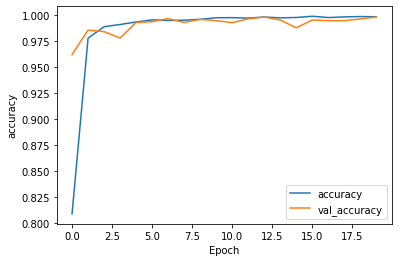

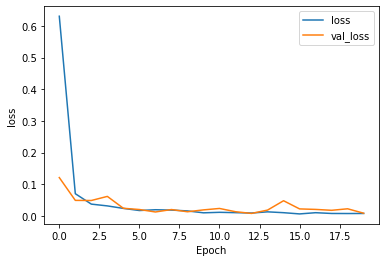

In [61]:
def plot_metric(history, metric):
    plt.plot(history[metric])
    plt.plot(history['val_' + metric])
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.show()

plot_metric(loaded_history, 'accuracy')
plot_metric(loaded_history, 'loss')

print(history)